# Lab 6 Unsupervised Learning, 

by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es) and [oscar.barquero@urjc.es](mailto:oscar.barquero@urjc.es)

Update Dec-2023

In this notebook we will analyze clustering methods over the Pima Indiand Diabetes dataset.

## Table of Contents

0. [Preliminaries](#preliminaries)
1. [K-means](#k_means) 
2. [Hierchical clustering](#hierarchical)
3. [Project Ideas](#ideas)

---
<a id='preliminaries'></a>
# 0 . Preliminaries

## Import libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

# sklearn
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_samples, silhouette_score

In [13]:
def load_pima_indian(filename):

    # Read the database
    db = pd.read_csv(filename)

    # some preprocessing
    db['Glucose'] = db['Glucose'].replace(0, np.nan)
    db['BloodPressure'] = db['BloodPressure'].replace(0, np.nan)
    db['SkinThickness'] = db['SkinThickness'].replace(0, np.nan)
    db['Insulin'] = db['Insulin'].replace(0, np.nan)
    db['BMI'] = db['BMI'].replace(0, np.nan)
    db = db.fillna(np.mean(db))
    
    # columns rename
    columns_names = [
        'pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin',
        'bmi', 'diabetes_pedigree_function', 'age', 'outcome'
    ]
    db.columns = columns_names
    
    # Create X and Y
    X = db.drop(['outcome'], axis = 1)
    y = db['outcome']

    return X,y

def load_life_expectancy(filename):

    # Read the database
    df = pd.read_csv(filename, sep=',', decimal='.')

    # do some cleaning to the column's names
    def clean_columns(column_name):
        return column_name.strip().lower().replace('  ',' ').replace(' ','_')

    df.columns = [clean_columns(col_name) for col_name in df.columns]

    # rename this column
    df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

    # values imputation
    df = df.fillna(df.mean())

    # Encoding
    df['status'] = df['status'].replace(['Developing', 'Developed'],[0, 1])

    df = pd.concat([df, pd.get_dummies(df['country'], prefix='country', drop_first=True)], axis=1)
    df = df.drop(['country'], axis=1)

    # Drop unnecesary columns
    df = df.drop(columns = ['infant_deaths'])

    # Create X and Y
    X = df.drop(['life_expectancy'], axis = 1)
    y = df['life_expectancy']

    print('Predictors: ', X.shape)
    print('Target: ', y.shape)

    return X, y

In [14]:
def load_examples():
    # case 1: general case
    X1, y1 = make_blobs(random_state=1)

    # case 2: clusters are of different densities and sizes
    X2, y2 = make_blobs(n_samples=200, cluster_std=[1.0, 2.5, 0.5], random_state=170)

    # case 3: Anisotropic distribution
    X3, y3 = make_blobs(random_state=170, n_samples=600)
    rng = np.random.RandomState(74)
    transformation = rng.normal(size=(2, 2))
    X3 = np.dot(X3, transformation)

    # case 4: two_moons data 
    X4, y4 = make_moons(n_samples=200, noise=0.05, random_state=0)
    
    return X1, y1, X2, y2, X3, y3, X4, y4

def plot_scatter(X,title, cluster_labels = None, centroids = None):
    
    eps = X.std() / 5.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    
    if cluster_labels is not None:
        plt.scatter(X[:, 0], X[:, 1], s = 100, alpha = 0.5, c = cluster_labels)
        if centroids is not None:
            plt.scatter(centroids[:,0],centroids[:,1],marker = '^', c = 'r', s = 200)
    else:    
        plt.scatter(X[:, 0], X[:, 1], s = 100, alpha = 0.5)
        
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$x_2$',fontsize=16)
    plt.axis('equal')
    #plt.axis([x_min, x_max, y_min, y_max])
    #ax = plt.gca()
    #ax.set_aspect('equal', 'box')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)



def plot_silhouette(X, k, cluster_labels, centroids):
    
    # silhouette_score
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    #--- Do the ploting
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=100, alpha=0.5, c=colors)
    ax2.scatter(centroids[:,0],centroids[:,1],marker = 'x', c = 'k', s = 200)
    ax2.set_xlabel('$x_1$',fontsize=16)
    ax2.set_ylabel('$x_2$',fontsize=16)

    plt.show()
    
#https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif covariance.shape == (2,): # this was added from the original code
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    else: 
        angle = 0
        width = 2*covariance 
        height= 2*covariance
        
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

## Load dataset

In this lab exercise you are using the Pima Indian Diabetes data. Your hypothesis is that **there might be groups of patients with similar behavior** and you want to get some insights about them.

In [16]:
X, y = load_pima_indian('pima_indian_diabetes.csv')
feat_names = X.columns

---
<a id='k_means'></a>
# 1. K-means

In [17]:
from sklearn.preprocessing import StandardScaler

X1 = X[['bmi','glucose']].values
X1 = StandardScaler().fit_transform(X1)

<font color='red'>why do we need to standardize data ? </font>

In [18]:
X1.shape

(768, 2)

C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


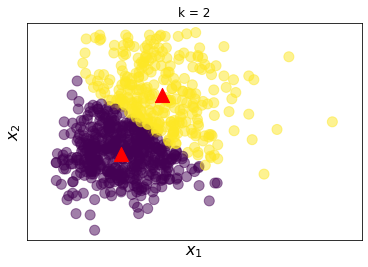

In [60]:
from sklearn.cluster import KMeans

# build the clustering model
k = 2
kmeans = KMeans(n_clusters=k, random_state=20, n_init=10)
kmeans.fit(X1)

# Centroids 
centroids = kmeans.cluster_centers_

# Labels
cluster_labels = kmeans.labels_

# do the plotting
plot_scatter(X1,'k = ' + str(k), cluster_labels, centroids)

What if we use the target variable `y`?

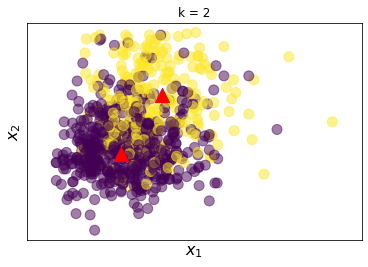

In [61]:
# do the plotting
plot_scatter(X1,'k = ' + str(k), y, centroids)
plt.show()

Careful here, the purpose is to group our observations not classify them (so there might be subgroups within our observations having the same or different outcome)

### How many cluster are there?

C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

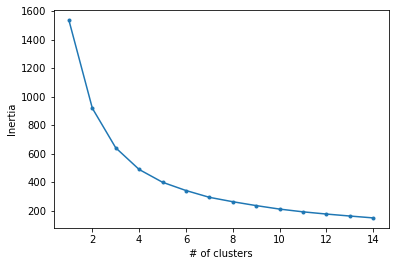

In [62]:
K = range(1,15)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(X1)
    inertia.append(kmeans.inertia_)
    
plt.plot(K,inertia,'.-')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

## Use the silhouette analysis


Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.[1] It was proposed by Belgian statistician Peter Rousseeuw in 1987.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 

If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. 

A clustering with an average silhouette width of over 0.7 is considered to be "strong", a value over 0.5 "reasonable" and over 0.25 "weak", but with increasing dimensionality of the data, it becomes difficult to achieve such high values because of the curse of dimensionality, as the distances become more similar. The silhouette score is specialized for measuring cluster quality when the clusters are convex-shaped, and may not perform well if the data clusters have irregular shapes or are of varying sizes.

**Play a little bit with the number of clusters**

C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


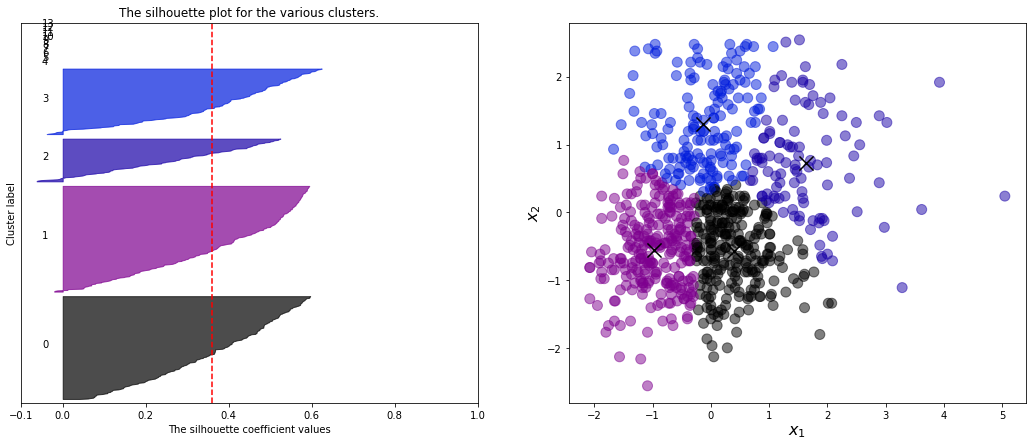

In [63]:
kmeans = KMeans(n_clusters=4).fit(X1)
plot_silhouette(X1,k,kmeans.labels_,kmeans.cluster_centers_)

### Let's analyze our observations depending on the cluster label

In [64]:
df = X.copy()
df['cluster_label'] = cluster_labels
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,cluster_label
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


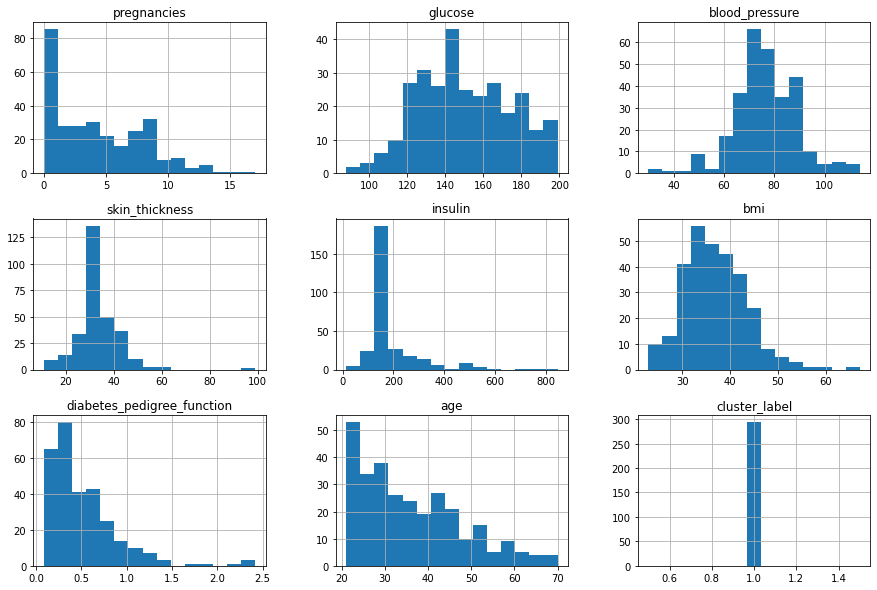

In [65]:
df[df.cluster_label==1].hist(figsize=(15,10),bins=15)
plt.show()

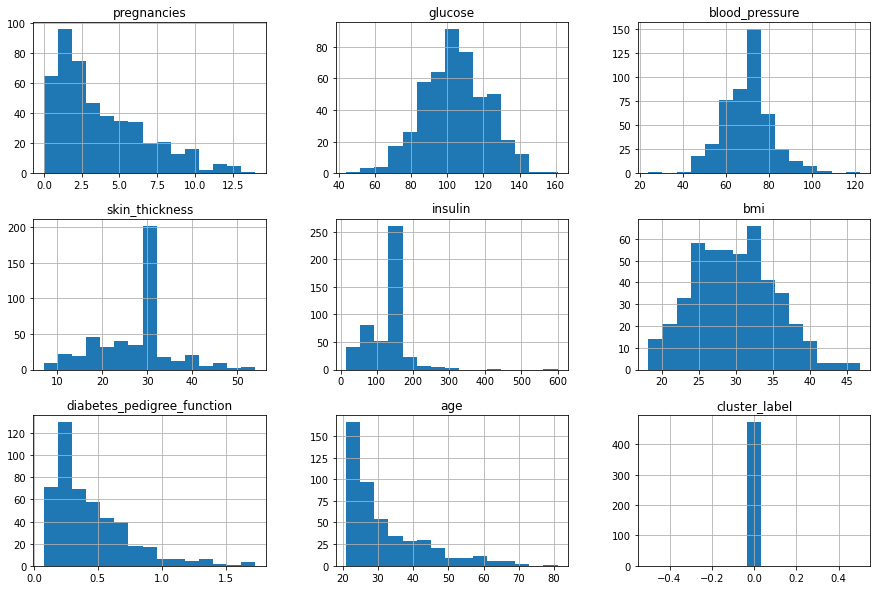

In [66]:
df[df.cluster_label==0].hist(figsize=(15,10),bins=15)
plt.show()

<div class = "alert alert-info">
<b>Note:</b> You can use either <b>cluster_labels</b> or <b>outcome</b> in the above representation
</div>

### PCA & K-means

Two options here:
    
1. K-means + PCA representation
2. PCA dimensionality reduction + K-means

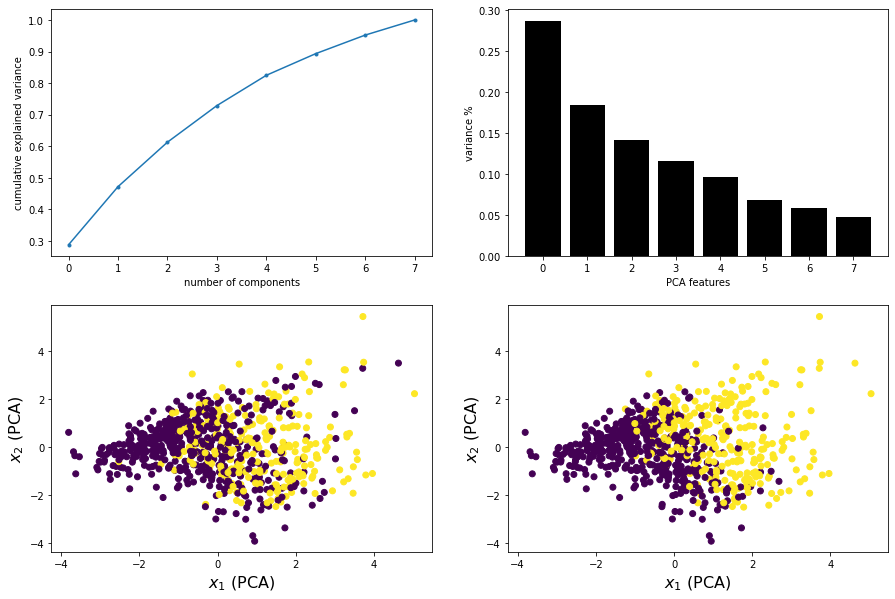

In [67]:
from sklearn.decomposition import PCA

# scaling
X_scaled = StandardScaler().fit_transform(X)

# Number of components
pca = PCA().fit(X_scaled)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# Data visualization (just 2 components)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

plt.subplot(2,2,2)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(2,2,3)
plt.scatter(X_pca[:,0],X_pca[:,1], c=y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$x_2$ (PCA)',fontsize=16)

plt.subplot(2,2,4)
plt.scatter(X_pca[:,0],X_pca[:,1], c=cluster_labels)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$x_2$ (PCA)',fontsize=16)

plt.show()

#### Option 2:

C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\enriq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


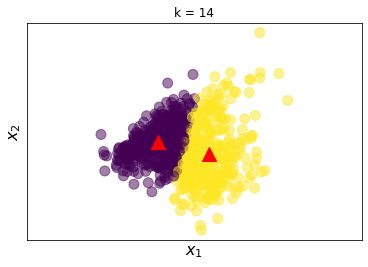

In [70]:
X_pca = PCA(n_components=2).fit_transform(X_scaled)
kmeans = KMeans(n_clusters = 2).fit(X_pca)

# Centroids 
centroids = kmeans.cluster_centers_

# Labels
cluster_labels = kmeans.labels_

# do the plotting
plot_scatter(X_pca,'k = ' + str(k), cluster_labels, centroids)
plt.show()

---
<a id='hierarchical'></a>
# 2. Hierarchical clustering

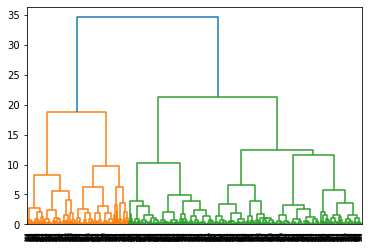

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X1, 'ward')
dendrogram(Z)
plt.show()

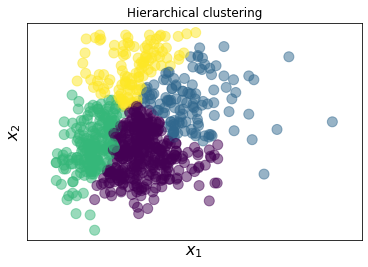

In [57]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4).fit(X1)
plot_scatter(X1,'Hierarchical clustering', agg.labels_) 

---
<a id='ideas'></a>
# Project Ideas


Here there are some ideas that you might want to consider for your project:

- Apply the k-means algorithm to your dataset, was it helpful? Did you get any insight? Comment on the number of cluster you used.

- What if you used Hierarchical clustering? Any differences? 


In all above, justify your decisions.